# Model Evaluation and Analysis
This notebook loads predictions from all models (SARIMA, SIR, SEIR) and visualizes their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure figure size
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Define paths
pred_dir = Path('../predictions')

# Load predictions
models = {}

# SARIMA
sarima_path = pred_dir / 'sarima_predictions.csv'
if sarima_path.exists():
    models['SARIMA'] = pd.read_csv(sarima_path)
    models['SARIMA']['date'] = pd.to_datetime(models['SARIMA']['date'])
    print(f"Loaded SARIMA predictions: {len(models['SARIMA'])} rows")
else:
    print(f"Warning: {sarima_path} not found")

# SIR
sir_path = pred_dir / 'sir_predictions.csv'
if sir_path.exists():
    models['SIR'] = pd.read_csv(sir_path)
    models['SIR']['date'] = pd.to_datetime(models['SIR']['date'])
    print(f"Loaded SIR predictions: {len(models['SIR'])} rows")
else:
    print(f"Warning: {sir_path} not found")

# SEIR
seir_path = pred_dir / 'seir_predictions.csv'
if seir_path.exists():
    models['SEIR'] = pd.read_csv(seir_path)
    models['SEIR']['date'] = pd.to_datetime(models['SEIR']['date'])
    print(f"Loaded SEIR predictions: {len(models['SEIR'])} rows")
else:
    print(f"Warning: {seir_path} not found")

print(f"\nTotal models loaded: {len(models)}")

Loaded SARIMA predictions: 166 rows
Loaded SIR predictions: 103 rows
Loaded SEIR predictions: 103 rows

Total models loaded: 3


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Calculate metrics for each model and region
regions = ['ca', 'ma', 'ny', 'nat']
metrics_summary = []

for model_name, df in models.items():
    for region in regions:
        region_data = df[df['region'] == region]
        if len(region_data) > 0:
            metrics = calculate_metrics(
                region_data['true_ili'].values,
                region_data['predicted_ili'].values
            )
            metrics_summary.append({
                'Model': model_name,
                'Region': region,
                **metrics
            })

metrics_df = pd.DataFrame(metrics_summary)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
 Model Region     RMSE      MAE      MAPE        R2
SARIMA     ca 0.795372 0.634178 17.571683  0.688010
SARIMA     ma 1.186155 0.741227 21.934634  0.340274
SARIMA     ny 0.561813 0.526430 12.118030  0.542764
SARIMA    nat 0.867084 0.658154 19.848309  0.595635
   SIR    nat 2.476105 1.791479 60.413916 -1.209985
  SEIR    nat 2.989577 2.492146 81.564481 -2.221593


### Regional PRedictions

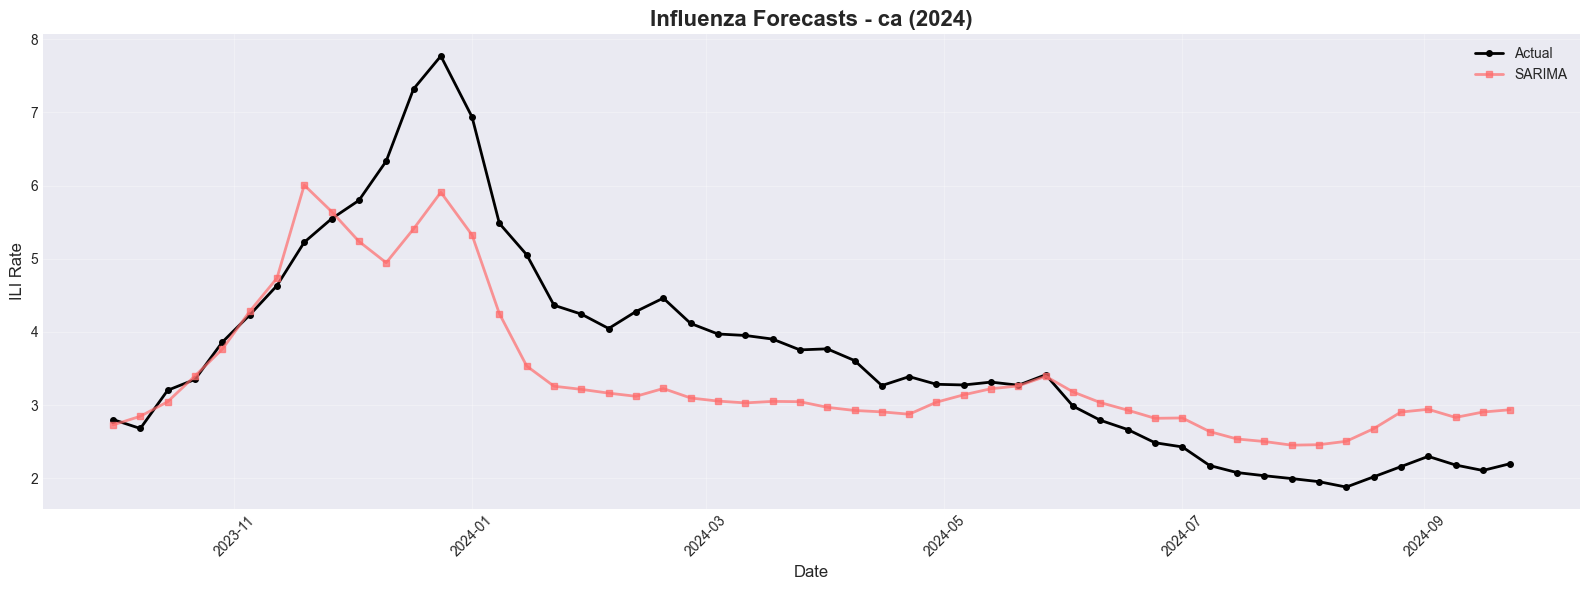

Plot saved: predictions/predictions_ca.png


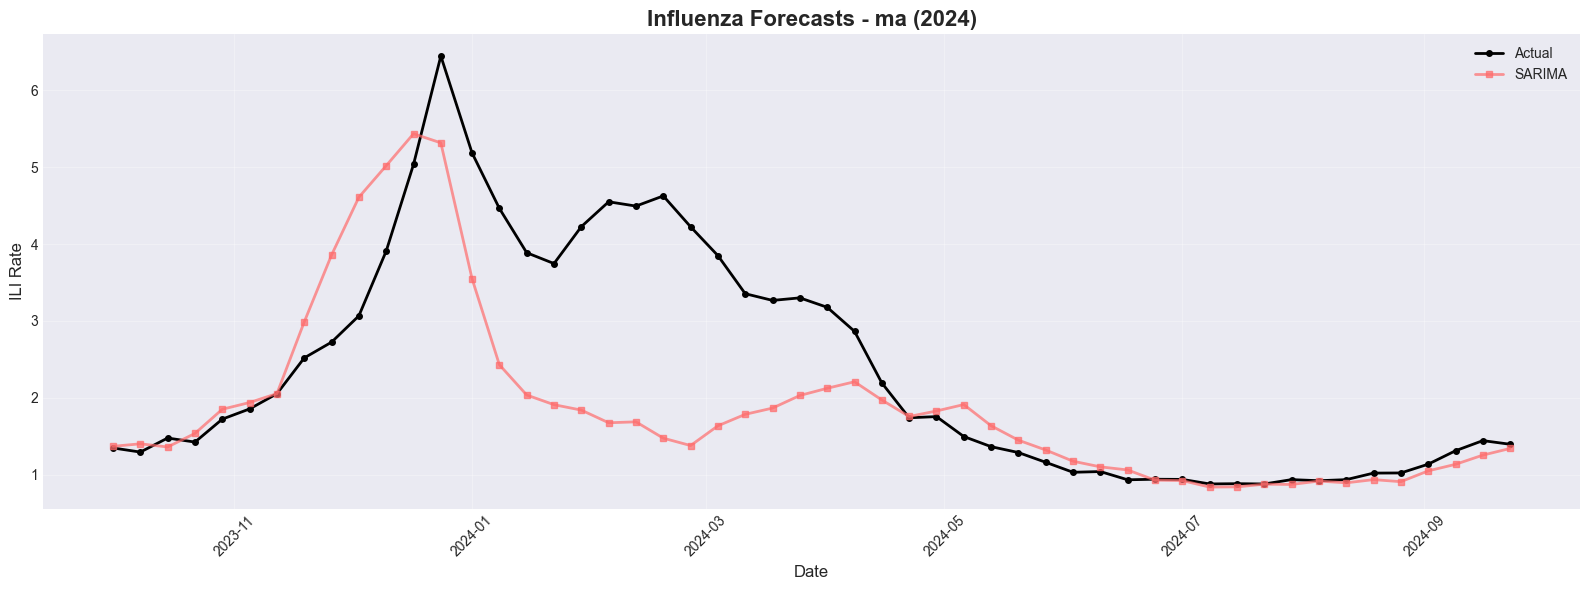

Plot saved: predictions/predictions_ma.png


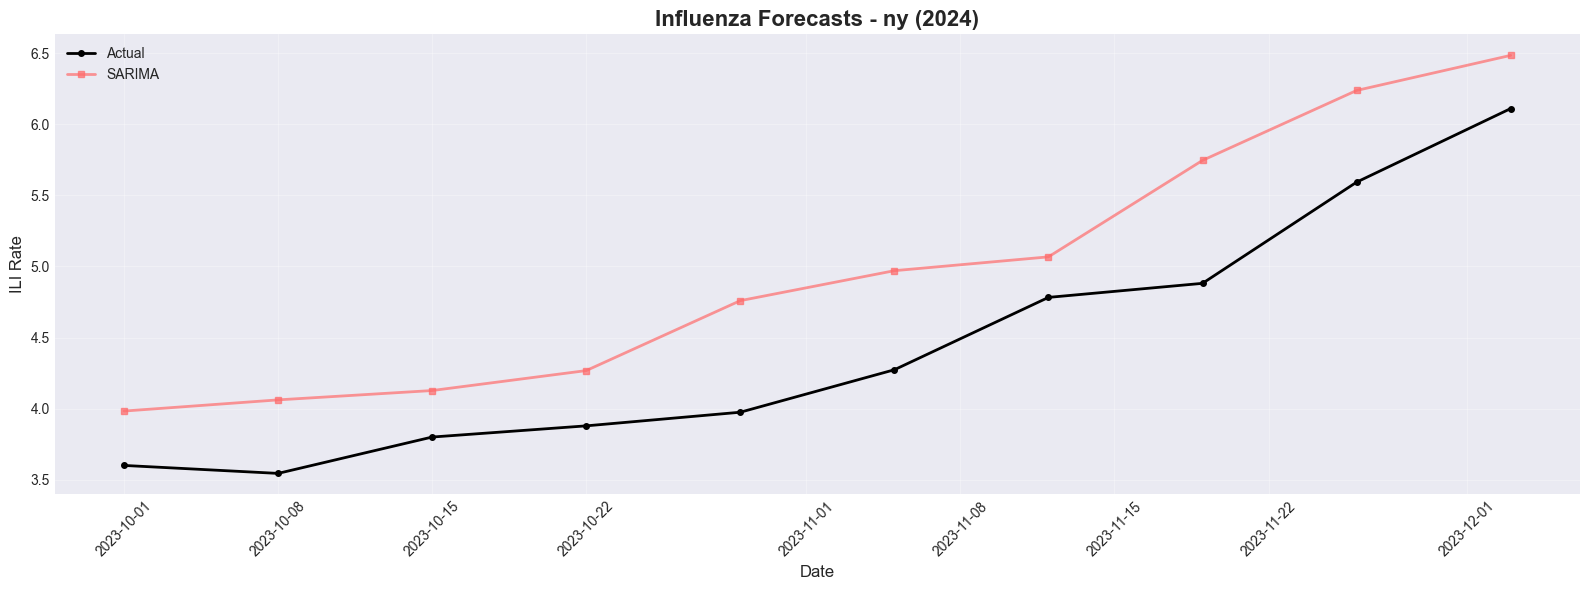

Plot saved: predictions/predictions_ny.png


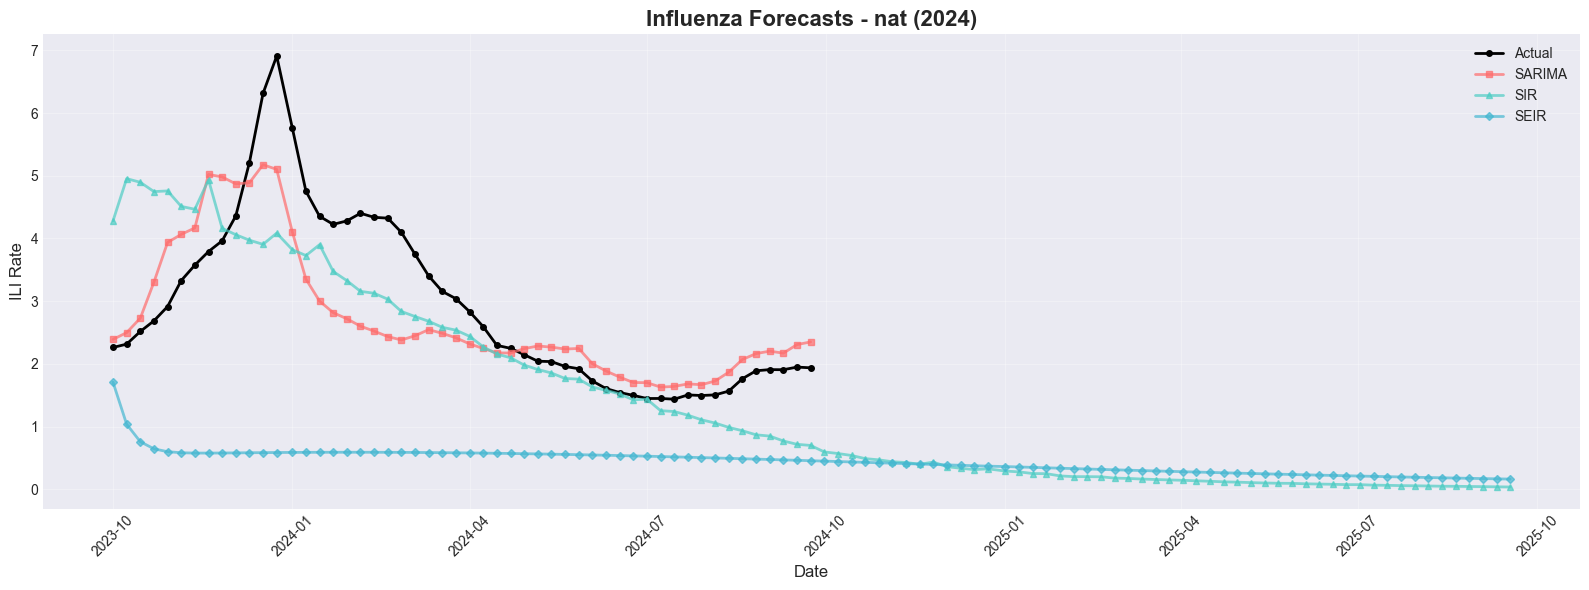

Plot saved: predictions/predictions_nat.png


In [4]:
# Plot predictions for each region
for region in regions:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Get actual values (from first available model)
    first_model = list(models.keys())[0]
    region_data = models[first_model][models[first_model]['region'] == region]
    
    if len(region_data) > 0:
        # Plot actual values
        ax.plot(region_data['date'], region_data['true_ili'], 
                'k-', linewidth=2, label='Actual', marker='o', markersize=4)
        
        # Plot predictions from each model
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        markers = ['s', '^', 'D']
        
        for idx, (model_name, df) in enumerate(models.items()):
            model_region_data = df[df['region'] == region]
            if len(model_region_data) > 0:
                ax.plot(model_region_data['date'], model_region_data['predicted_ili'],
                        linewidth=2, label=model_name, alpha=0.7,
                        marker=markers[idx % len(markers)], markersize=4,
                        color=colors[idx % len(colors)])
        
        ax.set_title(f'Influenza Forecasts - {region} (2024)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('ILI Rate', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'../predictions/predictions_{region}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plot saved: predictions/predictions_{region}.png")
    else:
        print(f"No data available for region: {region}")

### Residual Error Analysis

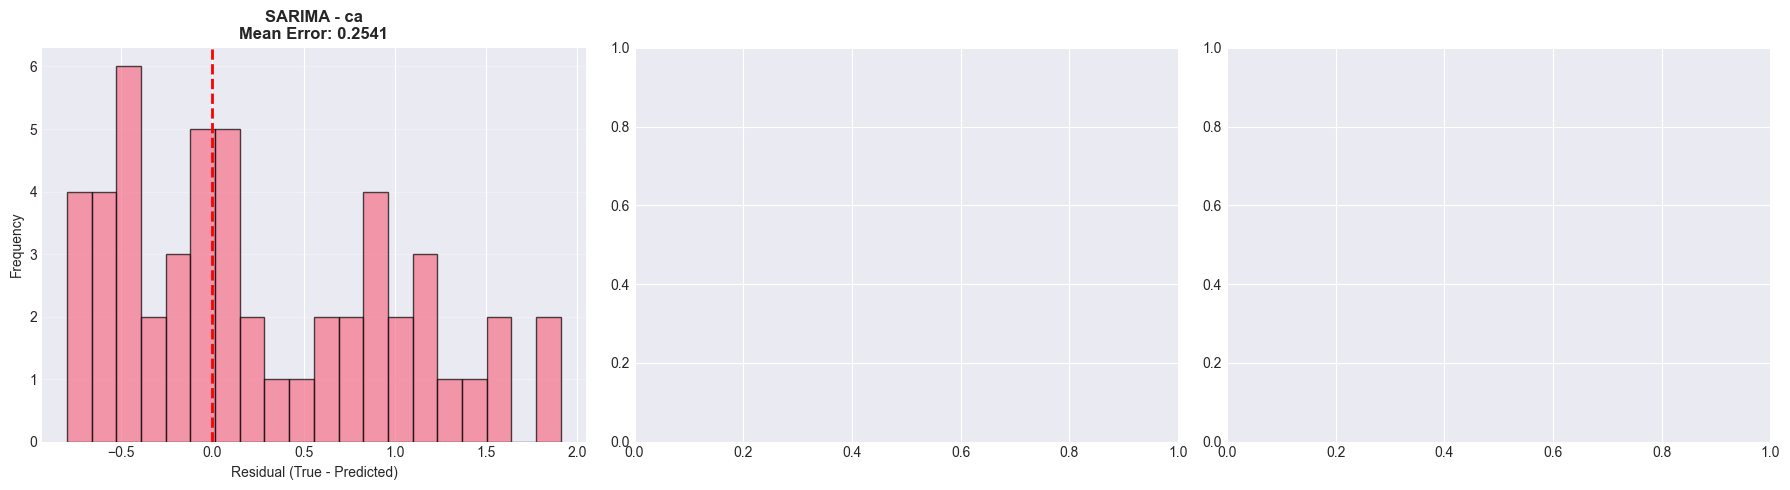

Residuals plot saved: predictions/residuals_ca.png


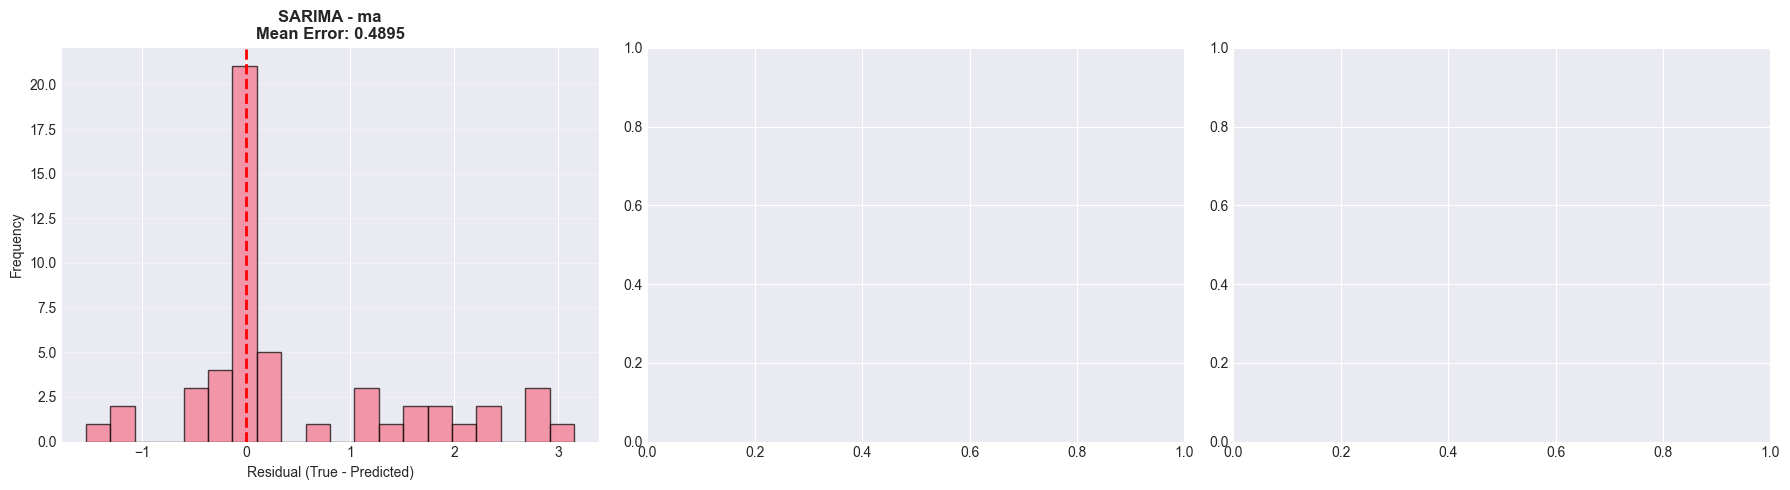

Residuals plot saved: predictions/residuals_ma.png


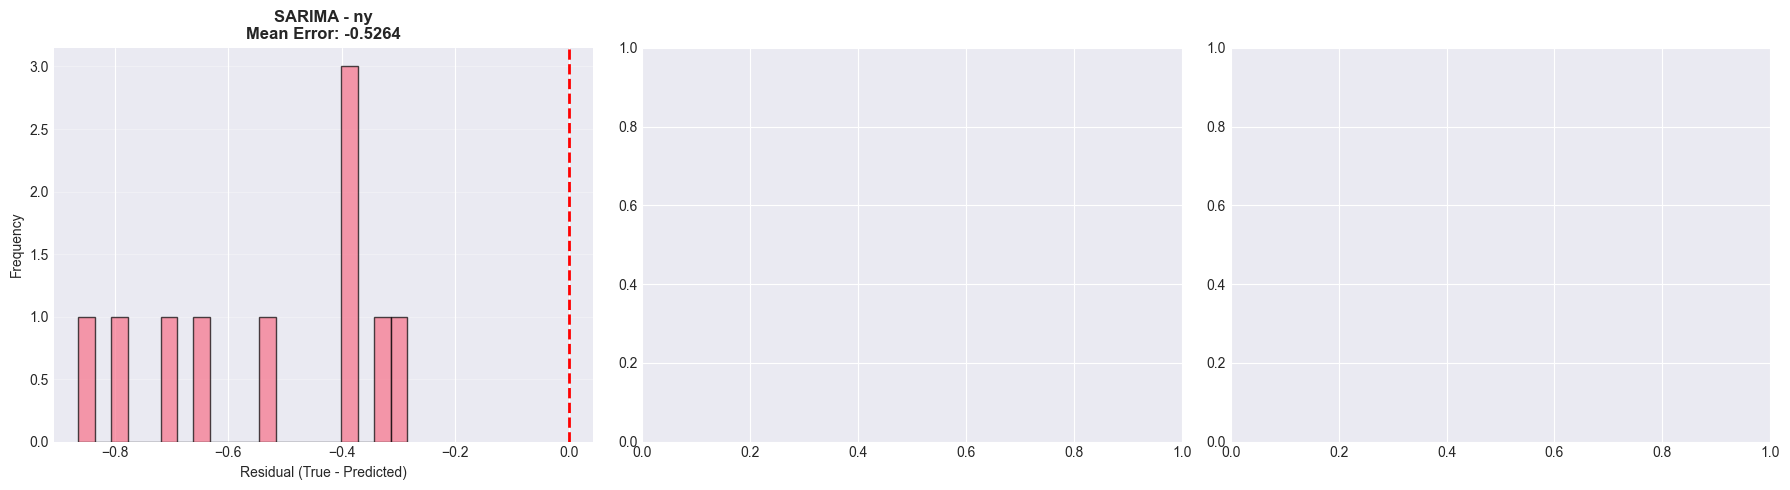

Residuals plot saved: predictions/residuals_ny.png


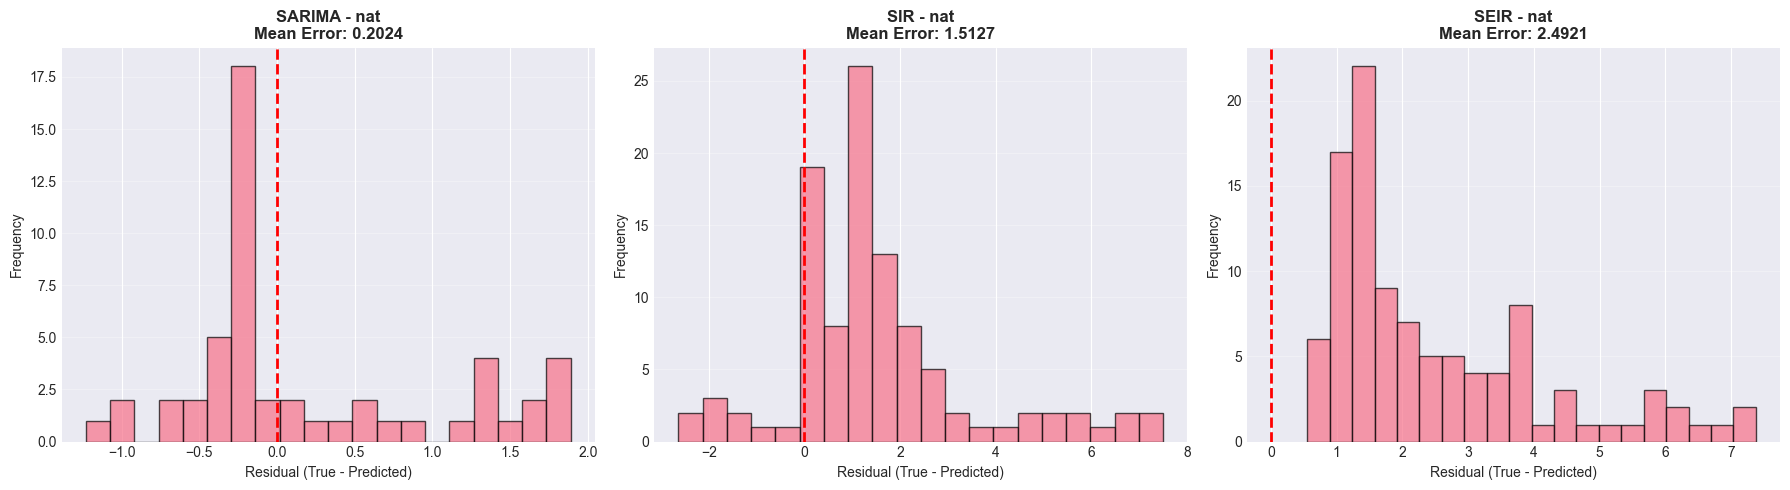

Residuals plot saved: predictions/residuals_nat.png


In [5]:
# Calculate residuals and plot error distribution
for region in regions:
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
    if len(models) == 1:
        axes = [axes]
    
    for idx, (model_name, df) in enumerate(models.items()):
        region_data = df[df['region'] == region]
        
        if len(region_data) > 0:
            # Calculate residuals
            residuals = region_data['true_ili'] - region_data['predicted_ili']
            
            # Plot histogram
            axes[idx].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
            axes[idx].axvline(0, color='red', linestyle='--', linewidth=2)
            axes[idx].set_title(f'{model_name} - {region}\nMean Error: {residuals.mean():.4f}',
                               fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Residual (True - Predicted)', fontsize=10)
            axes[idx].set_ylabel('Frequency', fontsize=10)
            axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../predictions/residuals_{region}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Residuals plot saved: predictions/residuals_{region}.png")

### Weekly Performance Analysis

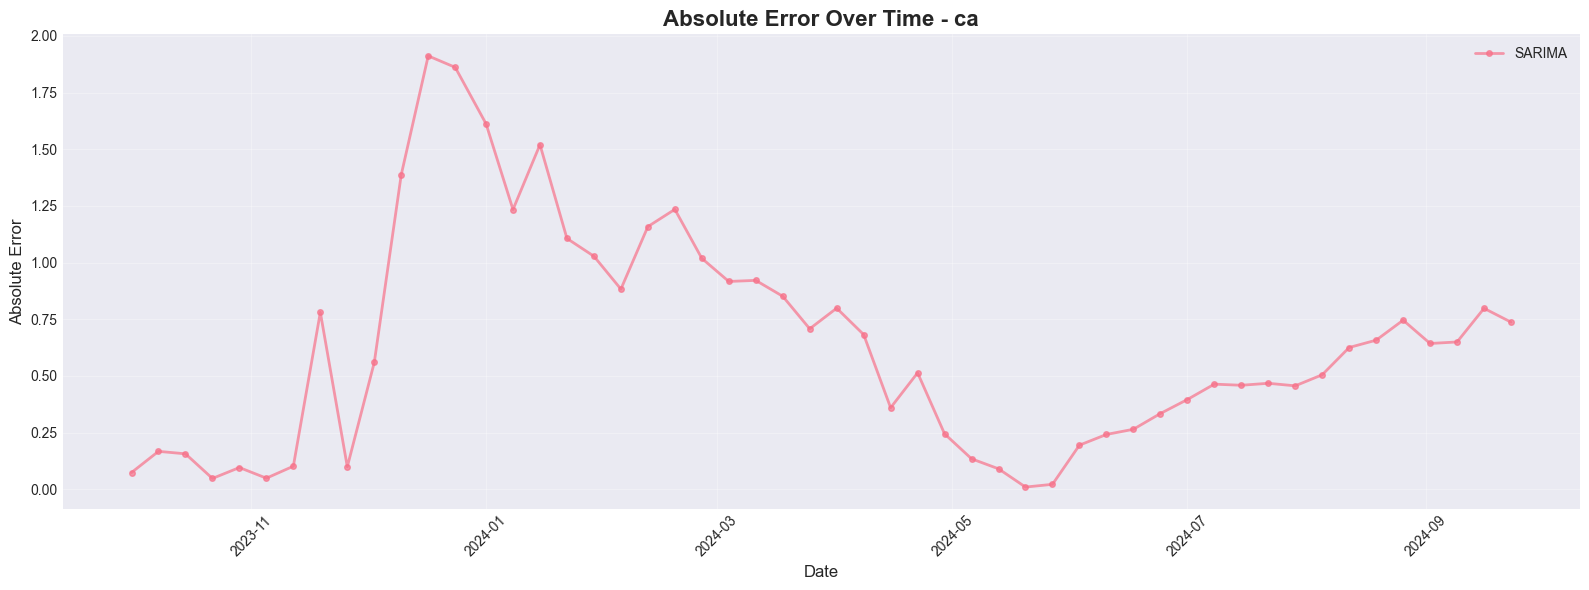

Error timeline plot saved: predictions/error_timeline_ca.png


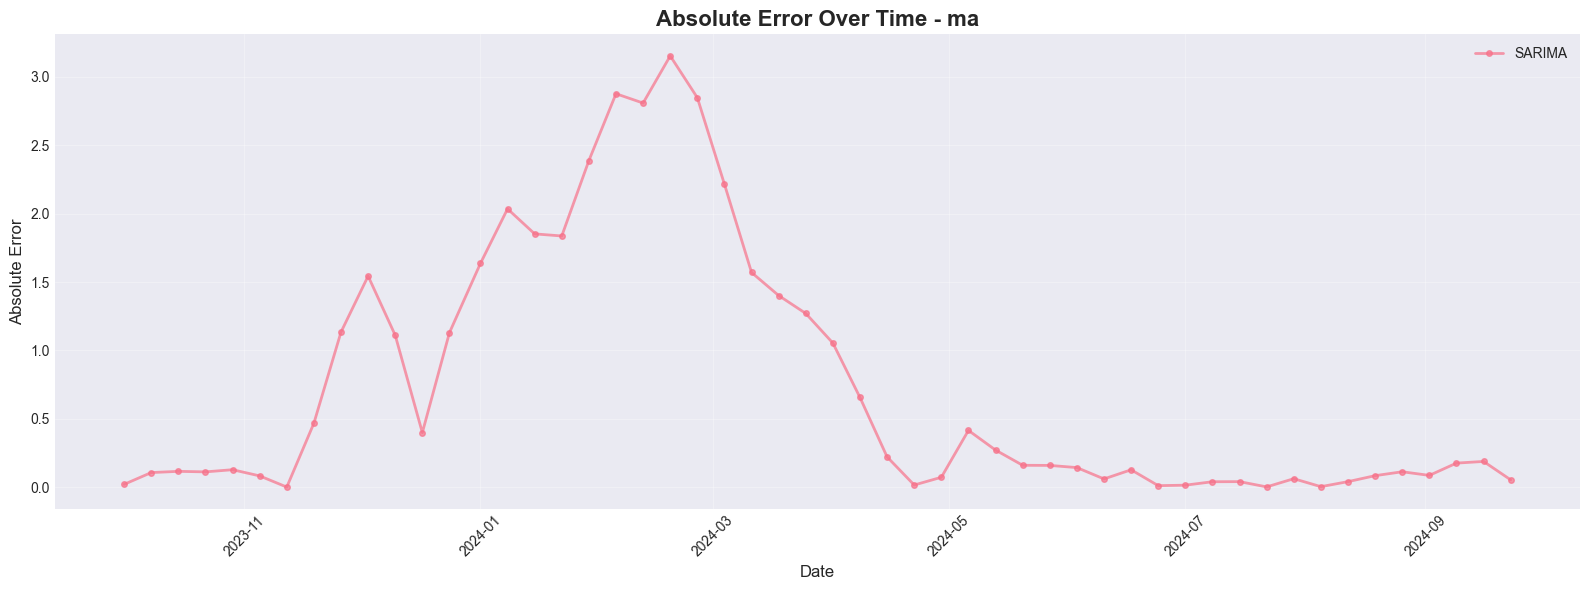

Error timeline plot saved: predictions/error_timeline_ma.png


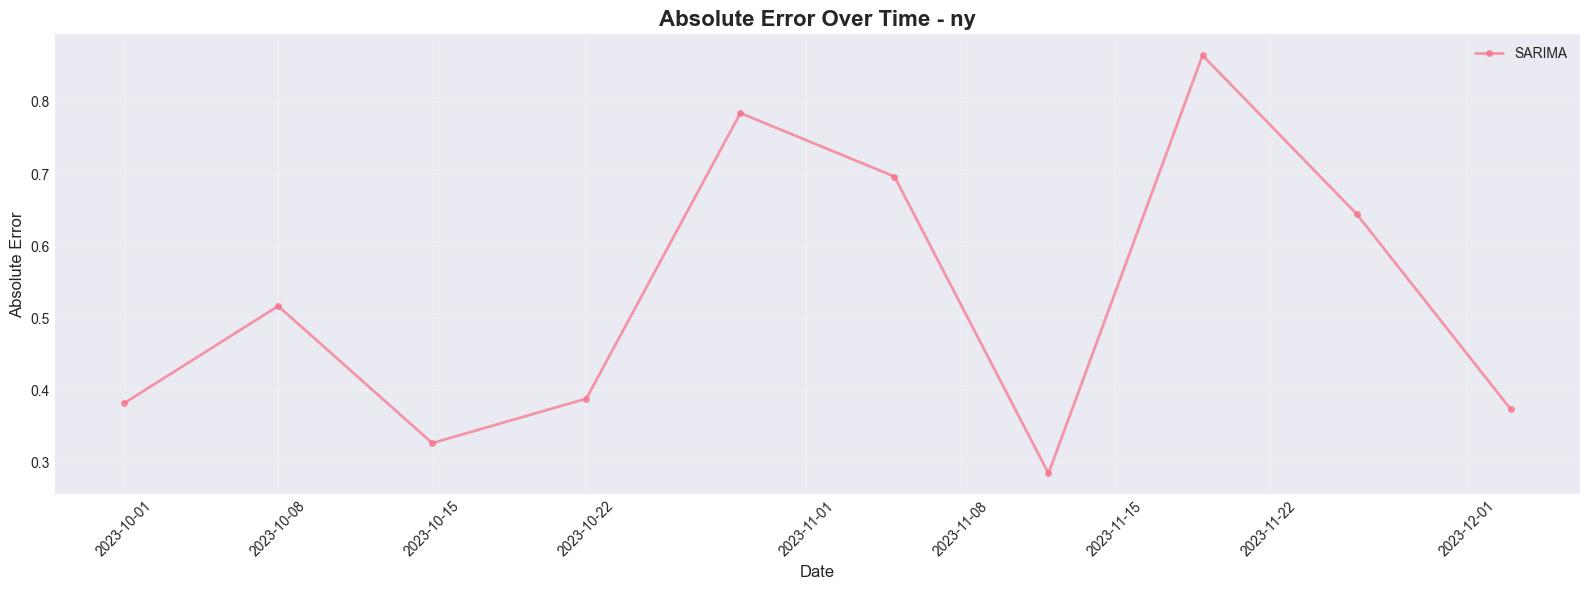

Error timeline plot saved: predictions/error_timeline_ny.png


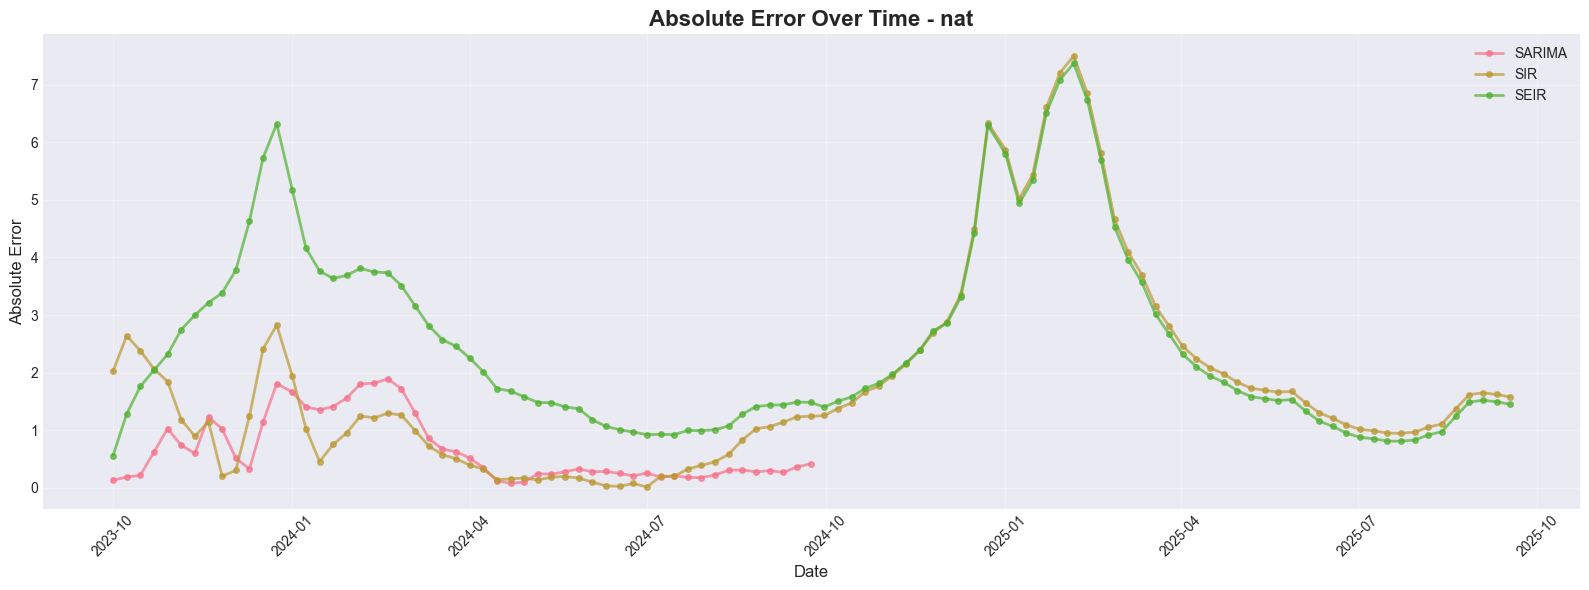

Error timeline plot saved: predictions/error_timeline_nat.png


In [6]:
# Calculate week-by-week errors
for region in regions:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    for model_name, df in models.items():
        region_data = df[df['region'] == region].copy()
        
        if len(region_data) > 0:
            # Calculate absolute error
            region_data['abs_error'] = np.abs(region_data['true_ili'] - region_data['predicted_ili'])
            
            ax.plot(region_data['date'], region_data['abs_error'],
                   linewidth=2, label=model_name, marker='o', markersize=4, alpha=0.7)
    
    ax.set_title(f'Absolute Error Over Time - {region}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig(f'../predictions/error_timeline_{region}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Error timeline plot saved: predictions/error_timeline_{region}.png")

### Overall Model Ranking


Overall Model Ranking (lower is better):
Model
SARIMA    1.0
SIR       2.0
SEIR      3.0
Name: Rank, dtype: float64


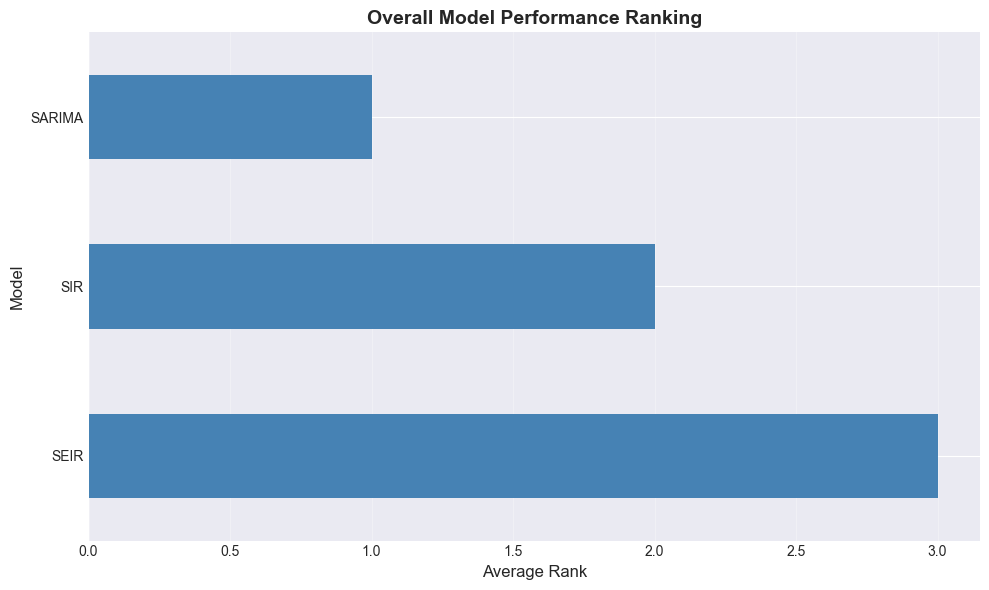


Ranking plot saved to: predictions/model_ranking.png


In [7]:
# Calculate average rank for each model across all metrics and regions
ranking_metrics = ['RMSE', 'MAE', 'MAPE']
rankings = []

for region in regions:
    region_metrics = metrics_df[metrics_df['Region'] == region]
    
    for metric in ranking_metrics:
        # Lower is better for RMSE, MAE, MAPE
        region_metrics_sorted = region_metrics.sort_values(metric)
        
        for rank, row in enumerate(region_metrics_sorted.itertuples(), 1):
            rankings.append({
                'Model': row.Model,
                'Region': region,
                'Metric': metric,
                'Rank': rank
            })

ranking_df = pd.DataFrame(rankings)

# Calculate average rank per model
avg_ranking = ranking_df.groupby('Model')['Rank'].mean().sort_values()

print("\nOverall Model Ranking (lower is better):")
print(avg_ranking)

# Plot ranking
fig, ax = plt.subplots(figsize=(10, 6))
avg_ranking.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Average Rank', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Overall Model Performance Ranking', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../predictions/model_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRanking plot saved to: predictions/model_ranking.png")